In [1]:
#import packages
import numpy as np
import pandas as pd
import pickle

In [2]:
#Load features and target dataframe
import pickle

f = open('/home/henry/Insight/Yogee/Datasets/Model_dataset/ModelDf.pckl', 'rb')
ModelDf = pickle.load(f)
f.close()

In [3]:
#Remove 2017 data
ModelDf = ModelDf[ModelDf['year'] != 2017]
ModelDf = ModelDf.reset_index(drop=True)

#Reduced land area size
ModelDf.loc[:,'LandArea'] = ModelDf.loc[:,'LandArea']/100000


In [4]:
#Get zipcodes in the dataset

#Load population dataset
Population2011FileLoc = "/home/henry/Insight/Yogee/Datasets/NY_Population_dataset/ACS_11_5YR_B01003/ACS_11_5YR_B01003_with_ann.csv"
Population2011Df = pd.read_csv(Population2011FileLoc)

#Get zipcodes to use
zipcodes = Population2011Df.loc[:,'GEO.id2']

In [5]:
#remove zipcodes with less than 100 people
for i in range(0,zipcodes.shape[0]):
    if Population2011Df.loc[i,'HD01_VD01'] < 100:
        zipcode = zipcodes[i]
        ModelDf = ModelDf[ModelDf['zip'] != zipcode]
        zipcodes = zipcodes.drop(i)
zipcodes = zipcodes.reset_index(drop=True)

In [6]:
ModelDf[ModelDf['zip'] == 10002]


,zip,year,population,FemaleRatio,Income,LandArea,PopDensity,NewStudio,TotalStudio,NewStudioNextYear,NewStudioNextYearBin,populationDifference,FemaleRatioDifference,IncomeDifference,PopDensityDifference
12,10002.0,2011.0,81335.0,109.289617,32407,22.7767,0.035710,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN
13,10002.0,2012.0,80323.0,109.649126,32265,22.7767,0.035265,0.0,0.0,0.0,0,-1012.0,0.359509,-142.0,-0.000444
14,10002.0,2013.0,82191.0,106.496271,33218,22.7767,0.036086,0.0,0.0,0.0,0,1868.0,-3.152856,953.0,0.000820
15,10002.0,2014.0,79894.0,108.459873,32966,22.7767,0.035077,0.0,0.0,1.0,1,-2297.0,1.963603,-252.0,-0.001008
16,10002.0,2015.0,80736.0,107.991362,33726,22.7767,0.035447,1.0,1.0,0.0,0,842.0,-0.468511,760.0,0.000370
17,10002.0,2016.0,78096.0,107.526882,35594,22.7767,0.034288,0.0,1.0,0.0,0,-2640.0,-0.464481,1868.0,-0.001159


In [7]:
#create test set by selecting 2016 data
TestData = ModelDf[ModelDf['year'] == 2016]
TestData = TestData.reset_index(drop=True)


In [8]:
#create valiation set by selecting 2015 data
ValidData = ModelDf[ModelDf['year'] == 2015]
ValidData = ValidData.reset_index(drop=True)


In [9]:
#create train set by removing 2015 and 2016 data
TrainData = ModelDf[(ModelDf['year'] != 2016) & (ModelDf['year'] != 2015)]
TrainData = TrainData.reset_index(drop=True)


In [10]:
#Separate predictor and target variables
TestDataX = TestData.loc[:,['population','FemaleRatio','Income','LandArea','PopDensity','TotalStudio']]
TestDataY = TestData.loc[:,['NewStudioNextYearBin']]
ValidDataX = ValidData.loc[:,['population','FemaleRatio','Income','LandArea','PopDensity','TotalStudio']]
ValidDataY = ValidData.loc[:,['NewStudioNextYearBin']]
TrainDataX = TrainData.loc[:,['population','FemaleRatio','Income','LandArea','PopDensity','TotalStudio']]
TrainDataY = TrainData.loc[:,['NewStudioNextYearBin']]

In [11]:
# preprocessing of train, validation, and test datasets

from sklearn import preprocessing

#Fill in missing data and scale input data
imputer = preprocessing.Imputer()
TestDataTransX = imputer.fit_transform(TestDataX)/10000
TestDataScaledX = preprocessing.scale(TestDataTransX).tolist()
ValidDataTransX = imputer.fit_transform(ValidDataX)/10000
ValidDataScaledX = preprocessing.scale(ValidDataTransX).tolist()
TrainDataTransX = imputer.fit_transform(TrainDataX)/10000
TrainDataScaledX = preprocessing.scale(TrainDataTransX).tolist()

TestDataValuesY = TestDataY.values.ravel().tolist()
ValidDataValuesY = ValidDataY.values.ravel().tolist()
TrainDataValuesY = TrainDataY.values.ravel().tolist()



In [25]:
# Train and valid dataset for logistic regression

from sklearn import linear_model
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

RANDOM_STATE = 42

#make model pipeline to upsample with SMOTE and train logistic regression model
LR = linear_model.LogisticRegression()
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                         LR)
pipeline.fit(TrainDataScaledX,TrainDataValuesY)
LogValidY = pipeline.predict(ValidDataScaledX)
LogValidProbaY = pipeline.predict_proba(ValidDataScaledX) 
LogLoss = metrics.log_loss(ValidDataValuesY,LogValidY)
LogAcc = metrics.accuracy_score(np.round(ValidDataValuesY),np.round(LogValidY))
LogWeights = LR.coef_
LogConfusionMatrix = metrics.confusion_matrix(ValidDataValuesY, LogValidY)

LogTestY = pipeline.predict(TestDataScaledX)
LogTestProbaY = pipeline.predict_proba(TestDataScaledX) 
LogLoss = metrics.log_loss(TestDataValuesY,LogTestY)
LogAcc = metrics.accuracy_score(np.round(TestDataValuesY),np.round(LogTestY))
LogWeights = LR.coef_
LogConfusionMatrix = metrics.confusion_matrix(TestDataValuesY, LogTestY)
LogTruePos = LogConfusionMatrix[1,1]/(LogConfusionMatrix[1,1] + LogConfusionMatrix[1,0])
LogFalsePos = LogConfusionMatrix[0,1]/(LogConfusionMatrix[0,1] + LogConfusionMatrix[0,0])
LogROCUpperLeft = LogTruePos + (1-LogFalsePos)
LogWeights

array([[ 1.16410537, -0.05161535,  0.55225507, -0.36292239, -0.07892225,
         0.09569544]])

In [13]:
# Train and valid dataset for support vector machine

from sklearn import svm
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

RANDOM_STATE = 42

#make model pipeline to upsample with SMOTE and train logistic regression model
SVM = svm.SVC(C = .01, kernel = 'linear', probability = True)
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), SVM)

pipeline.fit(TrainDataScaledX,TrainDataValuesY)
SVMValidY = pipeline.predict(ValidDataScaledX)
SVMValidProbaY = pipeline.predict_proba(ValidDataScaledX) 
SVMLoss = metrics.log_loss(ValidDataValuesY,SVMValidY)
SVMAcc = metrics.accuracy_score(np.round(ValidDataValuesY),np.round(SVMValidY))
SVMWeights = SVM.coef_
SVMConfusionMatrix = metrics.confusion_matrix(ValidDataValuesY, SVMValidY)
SVMTruePos = SVMConfusionMatrix[1,1]/(SVMConfusionMatrix[1,1] + SVMConfusionMatrix[1,0])
SVMFalsePos = SVMConfusionMatrix[0,1]/(SVMConfusionMatrix[0,1] + SVMConfusionMatrix[0,0])
SVMROCUpperLeft = SVMTruePos + (1-SVMFalsePos)
SVMROCUpperLeft

SVMTestY = pipeline.predict(TestDataScaledX)   
SVMTestProbaY = pipeline.predict_proba(TestDataScaledX) 
SVMLoss = metrics.log_loss(TestDataValuesY,SVMTestY)
SVMAcc = metrics.accuracy_score(np.round(TestDataValuesY),np.round(SVMTestY))
SVMWeights = SVM.coef_
SVMConfusionMatrix = metrics.confusion_matrix(TestDataValuesY, SVMTestY)
SVMTruePos = SVMConfusionMatrix[1,1]/(SVMConfusionMatrix[1,1] + SVMConfusionMatrix[1,0])
SVMFalsePos = SVMConfusionMatrix[0,1]/(SVMConfusionMatrix[0,1] + SVMConfusionMatrix[0,0])
SVMROCUpperLeft = SVMTruePos + (1-SVMFalsePos)
SVMROCUpperLeft


1.6019061583577712

In [14]:
# Train and valid dataset for random forest
from sklearn import ensemble
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

RANDOM_STATE = 42

RF = ensemble.RandomForestClassifier(n_estimators=3 , max_depth=3)
#make model pipeline to upsample with SMOTE and random forest model
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), RF)
pipeline.fit(TrainDataScaledX,TrainDataValuesY)
RFValidY = pipeline.predict(ValidDataScaledX)  
RFValidProbaY = pipeline.predict_proba(ValidDataScaledX)    
RFLoss = metrics.log_loss(ValidDataValuesY,RFValidY)
RFAcc = metrics.accuracy_score(np.round(ValidDataValuesY),np.round(RFValidY))
RDFeatureImportances = RF.feature_importances_
RFConfusionMatrix = metrics.confusion_matrix(ValidDataValuesY, RFValidY)
RFTruePos = RFConfusionMatrix[1,1]/(RFConfusionMatrix[1,1] + RFConfusionMatrix[1,0])
RFFalsePos = RFConfusionMatrix[0,1]/(RFConfusionMatrix[0,1] + RFConfusionMatrix[0,0])
RFROCUpperLeft = RFTruePos + (1-RFFalsePos)

RFTestY = pipeline.predict(TestDataScaledX) 
RFTestProbaY = pipeline.predict_proba(TestDataScaledX)    
RFLoss = metrics.log_loss(TestDataValuesY,RFTestY)
RFAcc = metrics.accuracy_score(np.round(TestDataValuesY),np.round(RFTestY))
RDFeatureImportances = RF.feature_importances_
RFConfusionMatrix = metrics.confusion_matrix(TestDataValuesY, RFTestY)
RFTruePos = RFConfusionMatrix[1,1]/(RFConfusionMatrix[1,1] + RFConfusionMatrix[1,0])
RFFalsePos = RFConfusionMatrix[0,1]/(RFConfusionMatrix[0,1] + RFConfusionMatrix[0,0])
RFROCUpperLeft = RFTruePos + (1-RFFalsePos)
RFROCUpperLeft


/home/henry/anaconda3/envs/insight/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1.5868768328445748

In [15]:
# Train and valid dataset for gradient boosting
from sklearn import ensemble
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

RANDOM_STATE = 42

GB =  ensemble.GradientBoostingClassifier(n_estimators=5 , max_depth=4, learning_rate = 0.01)
#make model pipeline to upsample with SMOTE and gradient boosting model
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), GB)
pipeline.fit(TrainDataScaledX,TrainDataValuesY)
GBValidY = pipeline.predict(ValidDataScaledX)
GBValidProbaY = pipeline.predict_proba(ValidDataScaledX)    
GBLoss = metrics.log_loss(ValidDataValuesY,GBValidY)
GBAcc = metrics.accuracy_score(np.round(ValidDataValuesY),np.round(GBValidY))
GBFeatureImportances = GB.feature_importances_
GBConfusionMatrix = metrics.confusion_matrix(ValidDataValuesY, GBValidY)
GBTruePos = GBConfusionMatrix[1,1]/(GBConfusionMatrix[1,1] + GBConfusionMatrix[1,0])
GBFalsePos = GBConfusionMatrix[0,1]/(GBConfusionMatrix[0,1] + GBConfusionMatrix[0,0])
GBROCUpperLeft = GBTruePos + (1-GBFalsePos)
GBROCUpperLeft

GBTestY = pipeline.predict(TestDataScaledX) 
GBTestProbaY = pipeline.predict_proba(TestDataScaledX)    
GBLoss = metrics.log_loss(TestDataValuesY,GBTestY)
GBAcc = metrics.accuracy_score(np.round(TestDataValuesY),np.round(GBTestY))
GBFeatureImportances = GB.feature_importances_
GBConfusionMatrix = metrics.confusion_matrix(TestDataValuesY, GBTestY)
GBTruePos = GBConfusionMatrix[1,1]/(GBConfusionMatrix[1,1] + GBConfusionMatrix[1,0])
GBFalsePos = GBConfusionMatrix[0,1]/(GBConfusionMatrix[0,1] + GBConfusionMatrix[0,0])
GBROCUpperLeft = GBTruePos + (1-GBFalsePos)
GBROCUpperLeft

1.508045223028245

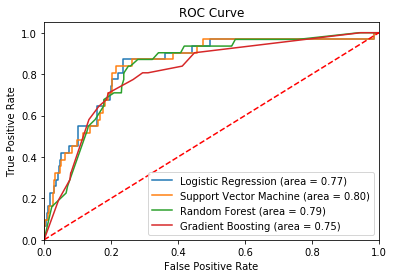

In [21]:
#plot ROC curves the models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logreg_roc_auc = roc_auc_score(TestDataValuesY, LogTestY)
fpr1, tpr1, thresholds1 = roc_curve(TestDataValuesY, LogTestProbaY[:,1])

support_roc_auc = roc_auc_score(TestDataValuesY, SVMTestY)
fpr2, tpr2, thresholds2 = roc_curve(TestDataValuesY, SVMTestProbaY[:,1])

forest_roc_auc = roc_auc_score(TestDataValuesY, RFTestY)
fpr3, tpr3, thresholds3 = roc_curve(TestDataValuesY, RFTestProbaY[:,1])

gradientboot_roc_auc = roc_auc_score(TestDataValuesY, GBTestY)
fpr4, tpr4, thresholds4 = roc_curve(TestDataValuesY, GBTestProbaY[:,1])

plt.figure()
plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % logreg_roc_auc)
plt.plot(fpr2, tpr2, label='Support Vector Machine (area = %0.2f)' % support_roc_auc)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % forest_roc_auc)
plt.plot(fpr4, tpr4, label='Gradient Boosting (area = %0.2f)' % gradientboot_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [17]:
#Train logistic regression model with full dataset to get predictive model

from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

RANDOM_STATE = 42

#Get train predict dataset and separate into X and Y
TrainData = ModelDf[(ModelDf['year'] != 2016)]
TrainData = TrainData.reset_index(drop=True)
TrainDataX = TrainData.loc[:,['population','FemaleRatio','Income','LandArea','PopDensity','TotalStudio']]
TrainDataY = TrainData.loc[:,['NewStudioNextYearBin']]

PredictData = ModelDf[ModelDf['year'] == 2016]
PredictData = PredictData.reset_index(drop=True)
PredictDataX = PredictData.loc[:,['population','FemaleRatio','Income','LandArea','PopDensity','TotalStudio']]
PredictDataY = PredictData.loc[:,['NewStudioNextYearBin']]

#Fill in missing data and scale input data
imputer = preprocessing.Imputer()
TrainDataTransX = imputer.fit_transform(TrainDataX)/10000
TrainDataScaledX = preprocessing.scale(TrainDataTransX).tolist()
PredictDataTransX = imputer.fit_transform(PredictDataX)/10000
PredictDataScaledX = preprocessing.scale(PredictDataTransX).tolist()

TrainDataValuesY = TrainDataY.values.ravel().tolist()
PredictDataValuesY = PredictDataY.values.ravel().tolist()

#Train model for logistic regression
#make model pipeline to upsample with SMOTE and train logistic regression model
LR = linear_model.LogisticRegression()
pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                         LR)
pipeline.fit(TrainDataScaledX,TrainDataValuesY)
LogPredictY = pipeline.predict(PredictDataScaledX)
LogPredictProbaY = pipeline.predict_proba(PredictDataScaledX) 
LogLoss = metrics.log_loss(PredictDataValuesY,LogPredictY)
LogAcc = metrics.accuracy_score(np.round(PredictDataValuesY),np.round(LogPredictY))
LogWeights = LR.coef_
LogConfusionMatrix = metrics.confusion_matrix(PredictDataValuesY, LogPredictY)
LogTruePos = LogConfusionMatrix[1,1]/(LogConfusionMatrix[1,1] + LogConfusionMatrix[1,0])
LogFalsePos = LogConfusionMatrix[0,1]/(LogConfusionMatrix[0,1] + LogConfusionMatrix[0,0])
LogROCUpperLeft = LogTruePos + (1-LogFalsePos)

#Put model predictions in dataframe
np.sum(LogPredictProbaY[:,1])

542.2746748447178

In [18]:
LogConfusionMatrix
23/31

0.7419354838709677

In [19]:
PredictDF = PredictData['zip']
ProbaDf = pd.DataFrame(LogPredictProbaY[:,1],columns=['NewStoreProbability'])
ScoreDf = pd.DataFrame(LogPredictProbaY[:,1]*10,columns=['Score'])
PredictDF = pd.concat([PredictDF, ProbaDf, ScoreDf], axis=1, sort=False)

In [20]:
import pickle

f = open('/home/henry/Insight/Yogee/Model/PredictModel.pckl', 'wb')
pickle.dump(pipeline, f)
f.close()

In [334]:
import pickle

f = open('/home/henry/Insight/Yogee/Model/PredictDF.pckl', 'wb')
pickle.dump(PredictDF, f)
f.close()

In [5]:
import pickle

f = open('/home/henry/Insight/Yogee/Model/PredictDF.pckl', 'rb')
PredictDF = pickle.load(f)
f.close()